<a href="https://colab.research.google.com/github/suribe1010/Kaggle/blob/master/AutonomousVehicles_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a script for me to understand how to implement a CNN ResNet50 in autonomous vehicles, in real-time.

In [0]:
!git clone https://github.com/abhinavsagar/Self-Driving-Car.git


fatal: destination path 'Self-Driving-Car' already exists and is not an empty directory.


In [0]:
!ls Self-Driving-Car

autonomous_car.ipynb  driving_log.csv  IMG  LICENSE  README.md	run.gif


In [0]:
## IMPORT NEEDED LIBRARIES

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as npimg
import os

## Keras
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense

import cv2
import pandas as pd
import random
import ntpath

## Sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [0]:
## STORE DATA
datadir = 'Self-Driving-Car'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Win 10\Desktop\benign\IMG\center_2019_07_22_20_38_15_382.jpg,C:\Users\Win 10\Desktop\benign\IMG\left_2019_07_22_20_38_15_382.jpg,C:\Users\Win 10\Desktop\benign\IMG\right_2019_07_22_20_38_15_382.jpg,0.0,0.0,0,0.000079
1,C:\Users\Win 10\Desktop\benign\IMG\center_2019_07_22_20_38_15_526.jpg,C:\Users\Win 10\Desktop\benign\IMG\left_2019_07_22_20_38_15_526.jpg,C:\Users\Win 10\Desktop\benign\IMG\right_2019_07_22_20_38_15_526.jpg,0.0,0.0,0,0.000082
2,C:\Users\Win 10\Desktop\benign\IMG\center_2019_07_22_20_38_15_669.jpg,C:\Users\Win 10\Desktop\benign\IMG\left_2019_07_22_20_38_15_669.jpg,C:\Users\Win 10\Desktop\benign\IMG\right_2019_07_22_20_38_15_669.jpg,0.0,0.0,0,0.000078
3,C:\Users\Win 10\Desktop\benign\IMG\center_2019_07_22_20_38_15_802.jpg,C:\Users\Win 10\Desktop\benign\IMG\left_2019_07_22_20_38_15_802.jpg,C:\Users\Win 10\Desktop\benign\IMG\right_2019_07_22_20_38_15_802.jpg,0.0,0.0,0,0.000078
4,C:\Users\Win 10\Desktop\benign\IMG\center_2019_07_22_20_38_15_937.jpg,C:\Users\Win 10\Desktop\benign\IMG\left_2019_07_22_20_38_15_937.jpg,C:\Users\Win 10\Desktop\benign\IMG\right_2019_07_22_20_38_15_937.jpg,0.0,0.0,0,0.000080


Bins:  [-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


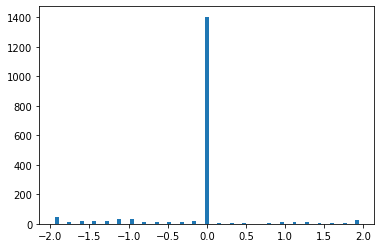

In [0]:
## VISUALIZE THE DATA

num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = bins[:-1] + bins[1:] #center the bins to 0

# Plot

plt.bar(center, hist, width=0.05)
print('Bins: ', bins)

Removed: 1203
Remaining: 540


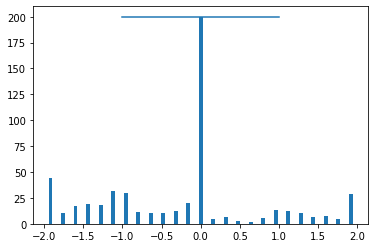

In [0]:
## REMOVE DATA STEERING = 0, GOING STRAIGHT
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    steering_angle = data['steering'][i]
    if steering_angle >= bins[j] and steering_angle <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
  
## Remove from extras from list
data.drop(data.index[remove_list], inplace=True)
print('Removed: {0}'.format(len(remove_list)))
print('Remaining: {0}'.format(len(data)))

## Plot
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [0]:
## IMAGE AND STEERING DATA INTO ARRAYS

def load_img_steering(datadir, df):
  
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)
print('Image Paths: ', image_paths[:8])
print('Steerings: ', steerings[:30])

Image Paths:  ['Self-Driving-Car/IMG/C:\\Users\\Win 10\\Desktop\\benign\\IMG\\center_2019_07_22_20_38_15_937.jpg'
 'Self-Driving-Car/IMG/C:\\Users\\Win 10\\Desktop\\benign\\IMG\\center_2019_07_22_20_38_17_547.jpg'
 'Self-Driving-Car/IMG/C:\\Users\\Win 10\\Desktop\\benign\\IMG\\center_2019_07_22_20_38_17_823.jpg'
 'Self-Driving-Car/IMG/C:\\Users\\Win 10\\Desktop\\benign\\IMG\\center_2019_07_22_20_38_18_123.jpg'
 'Self-Driving-Car/IMG/C:\\Users\\Win 10\\Desktop\\benign\\IMG\\center_2019_07_22_20_38_18_495.jpg'
 'Self-Driving-Car/IMG/C:\\Users\\Win 10\\Desktop\\benign\\IMG\\center_2019_07_22_20_38_18_633.jpg'
 'Self-Driving-Car/IMG/C:\\Users\\Win 10\\Desktop\\benign\\IMG\\center_2019_07_22_20_38_18_893.jpg'
 'Self-Driving-Car/IMG/C:\\Users\\Win 10\\Desktop\\benign\\IMG\\center_2019_07_22_20_38_19_514.jpg']
Steerings:  [ 0.        -1.        -0.1616194  0.        -0.713801  -0.293242
  0.        -0.5423487 -0.9730906 -1.         0.        -0.7876602
 -0.1776071 -0.8362509  0.         0.   

Training Samples: 432
Valid Samples: 108


Text(0.5, 1.0, 'Validation set')

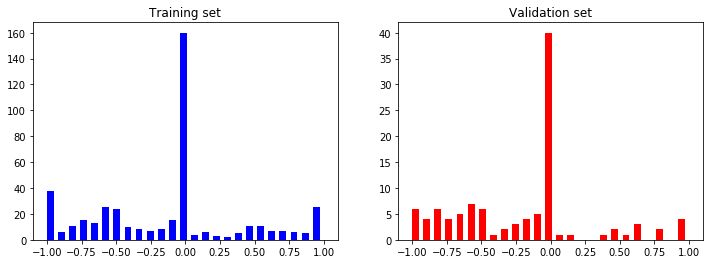

In [0]:
## DIVIDE DATA AND CHECK THAT IS VALID
#The next step was to split the data using the 80–20 rule which means using 80% of the data for training while the rest for testing the model on unseen images. Also, I plotted the sample training and validation steering angle distributions.
X_train, X_valid, Y_train, Y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=0)

## Check that data is valid
print("Training Samples: {}\nValid Samples: {}".format(len(X_train), len(X_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(Y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(Y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [0]:
## IMAGE PREPROCESSING
#I continued by doing some image processing. I cropped the image to remove the unnecessary features, changes the images to YUV format, 
#used gaussian blur, decreased the size for easier processing and normalized the values.
def img_preprocess(img):
  """Take in path of img, returns preprocessed image"""
  img = npimg.imread(img)
  
  ## Crop image to remove unnecessary features
  img = img[60:135, :, :]
  
  ## Change to YUV image
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  
  ## Gaussian blur
  img = cv2.GaussianBlur(img, (3, 3), 0)
  
  ## Decrease size for easier processing
  img = cv2.resize(img, (100, 100))
  
  ## Normalize values
  img = img / 255
  return img




In [78]:
## Get any image
image = image_paths[100]
#original_image = npimg.imread(image)
preprocessed_image = img_preprocess(image)



FileNotFoundError: ignored

In [0]:
## Converted all the images into numpy array

X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

FileNotFoundError: ignored

In [74]:
## Build the model. I have used ResNet as the pre-trained weights. I have removed the last 4 layers to make my own custom neural network.

from keras.applications import ResNet50
#Load the ResNet50 model
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

#I have removed the last 4 layers to make my own custom neural network.
# Freeze the layers except the last 4 layers
for layer in resnet.layers[:-4]:
    layer.trainable = False
 
for layer in resnet.layers:
    print(layer, layer.trainable)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 2s 0us/step
<keras.engine.input_layer.InputLayer object at 0x7f16df4d8588> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f16df4d8828> False
<keras.layers.convolutional.Conv2D object at 0x7f16df4d89b0> False
<keras.layers.normalization.BatchNormalization object at 0x7f16df4ee7f0> False
<keras.layers.core.Activation object at 0x7f16df4eedd8> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f16df4fa828> False
<keras.layers.pooling.MaxPooling2D object at 0x7f16d9205b00> False
<keras.layers.convolutional.Conv2D object at 0x7f16d9227e80> False
<keras.layers.normalization.BatchNormalization object at 0x7f16d922f2e8> False
<keras.layers.core.Activation object at 0x7f16d922ff60> False
<keras.layers.convolutional.Conv2D object at 0x7f16d92374e0> False
<keras.layers.normalization.BatchNormalization object at 0x7f16d91f1390> False
<keras.layers.core.Activation object at 0x7f16d91f1320> False
<keras.layers.convolutional

In [0]:
def nvidia_model():
  model = Sequential()
  
  model.add(resnet)#pre-trained model

  model.add(Dropout(0.5))
  
  model.add(Flatten()) # On top of the heavy resnet architecture, I have used the flatten layer to normalize the weights. 
  
  model.add(Dense(100, activation='elu')) #three dense layers with 100, 50 and 10 neurons
  model.add(Dropout(0.5)) #50% dropouts to reduce over-fitting the values to the training set.
  
  model.add(Dense(50, activation='elu'))# elu as the activation function
  model.add(Dropout(0.5))
  
  model.add(Dense(10, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
  return model

In [76]:
model = nvidia_model()
print(model.summary())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               3276900   
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
___

In [77]:
history = model.fit(X_train, Y_train, epochs=25, validation_data=(X_valid, Y_valid), batch_size=128, verbose=1, shuffle=1)

ValueError: ignored

In [79]:
#Finally, I trained the model for 25 epochs with a batch size of 128. 
#Also, I plotted the training and the validation loss as a function of epochs.

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

NameError: ignored